# Parámetros y Diferencias en Filtros Digitales FIR e IIR

Este laboratorio se centra en el análisis detallado de parámetros de filtros digitales y las diferencias fundamentales entre filtros FIR (Finite Impulse Response) e IIR (Infinite Impulse Response), con énfasis en sus características de diseño, implementación y aplicaciones prácticas.

## 1) Preparación

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from labs import filtros_digitales as fd
import soundfile as sf
from IPython.display import Audio, display, Image
from scipy import signal
import os


plt.rcParams.update({'figure.max_open_warning': 0})

### Diagrama de diseño de filtros

A continuación se muestra el diagrama conceptual del diseño de filtros digitales:

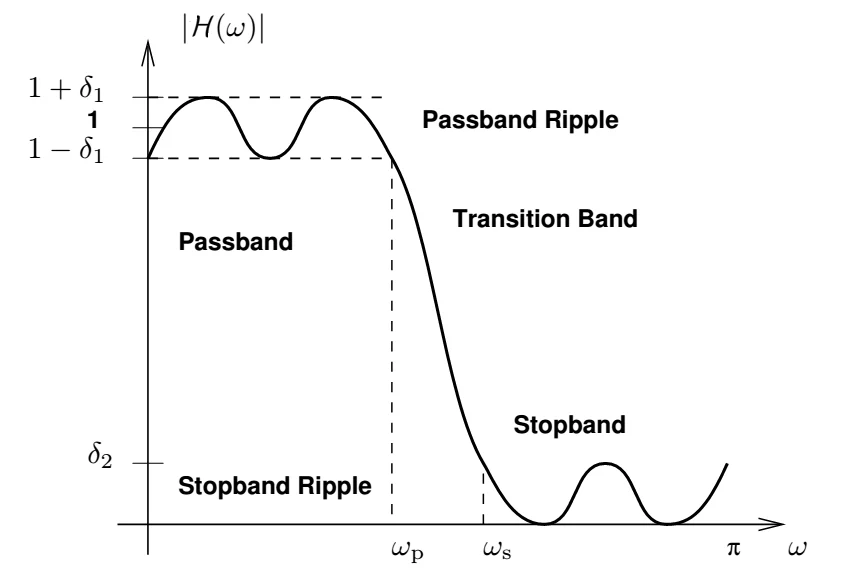

In [37]:
image_path = 'images/filter_design.png'
display(Image(image_path, width=800))

## 2) Teoría fundamental: Parámetros y características de filtros digitales

### 2.1 Parámetros críticos en el diseño de filtros

#### Parámetros de frecuencia:
- **Frecuencia de corte (fc)**: Define la transición entre banda de paso y banda de rechazo
- **Frecuencia de muestreo (fs)**: Determina el rango de frecuencias procesables (0 a fs/2, frecuencia de Nyquist)
- **Frecuencias normalizadas**: Todas las frecuencias se expresan como fracciones de fs/2

#### Parámetros de performance:
- **Ripple en banda de paso (Rp)**: Variación máxima permitida en la banda de paso (dB)
- **Atenuación en banda de rechazo (Rs)**: Supresión mínima requerida en la banda de rechazo (dB)
- **Ancho de banda de transición (Δf)**: Rango de frecuencias entre banda de paso y rechazo
- **Retardo de grupo (τg)**: Derivada negativa de la fase respecto a la frecuencia

#### Parámetros de implementación:
- **Orden del filtro (N)**: Número de polos/ceros, relacionado con la complejidad computacional
- **Número de coeficientes**: Para FIR = N+1, para IIR = orden del numerador + denominador
- **Estabilidad**: Todos los polos deben estar dentro del círculo unitario

### 2.2 Filtros FIR: Características y parámetros

#### Definición matemática:
$$
y[n] = \sum_{k=0}^{M} b_k \, x[n-k]
$$

Donde M+1 es el número de coeficientes (taps).

#### Ventajas de los filtros FIR:
1. **Estabilidad garantizada**: Sin retroalimentación, siempre estables
2. **Fase lineal**: Posible con coeficientes simétricos → retardo de grupo constante
3. **Implementación sencilla**: Solo requiere líneas de retardo y multiplicaciones
4. **Control preciso**: Diseño directo de la respuesta deseada

#### Parámetros específicos FIR:
- **Número de taps (M+1)**: Determina la selectividad y ancho de transición
- **Tipo de simetría**: Tipo I (M par, simétrico), Tipo II (M impar, simétrico)
- **Tipo de ventana**: Hamming, Hann, Blackman, Kaiser → compromiso ripple vs transición
- **Parámetro β (Kaiser)**: Controla el compromiso entre ripple y ancho de transición

#### Relaciones importantes FIR:
- **Ancho de transición ∝ 1/M**: Más coeficientes → transición más abrupta
- **Retardo = M/2 muestras**: Para filtros de fase lineal
- **Orden mínimo**: M ≈ (Rs - 8)/(14.36 * Δf_norm) para ventana Kaiser

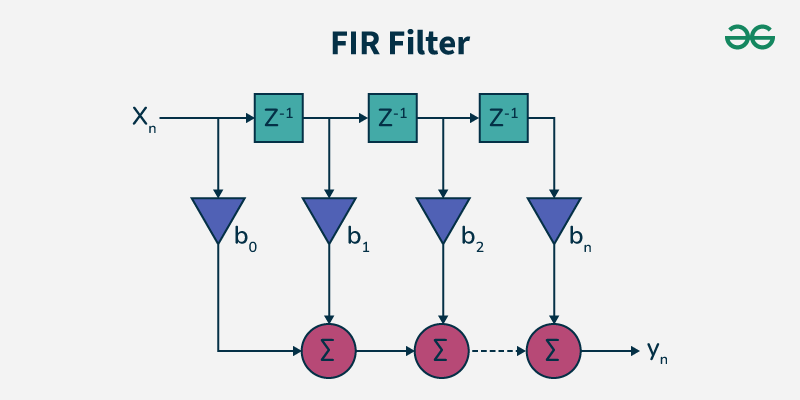

In [38]:
image_path = 'images/fir.png'
display(Image(image_path, width=800))

### 2.3 Filtros IIR: Características y parámetros

#### Definición matemática:
$$
y[n] = \sum_{k=0}^{M} b_k \, x[n-k] \;-\; \sum_{k=1}^{N} a_k \, y[n-k]
$$


#### Ventajas de los filtros IIR:
1. **Eficiencia computacional**: Pocos coeficientes para transiciones abruptas
2. **Analogía con filtros analógicos**: Diseños probados (Butterworth, Chebyshev)
3. **Mejor atenuación**: Mayor selectividad con menor orden

#### Parámetros específicos IIR:
- **Orden del filtro (N)**: Número de polos, determina la pendiente de caída
- **Tipo de aproximación**: Butterworth (plano), Chebyshev I/II (ripple), Ellíptico
- **Factor Q**: Para filtros resonantes, Q = fc/BW
- **Frecuencia de esquina**: Definida según el tipo (-3dB para Butterworth)

#### Tipos de filtros IIR y sus características:

**Butterworth:**
- Respuesta plana en banda de paso
- Transición suave
- Orden N → caída -20N dB/década

**Chebyshev Tipo I:**
- Ripple en banda de paso (parámetro Rp)
- Transición más abrupta que Butterworth
- Monotónico en banda de rechazo

**Chebyshev Tipo II:**
- Plano en banda de paso
- Ripple en banda de rechazo (parámetro Rs)
- Transición abrupta

**Ellíptico (Cauer):**
- Ripple en ambas bandas
- Transición más abrupta posible para orden dado
- Parámetros Rp y Rs

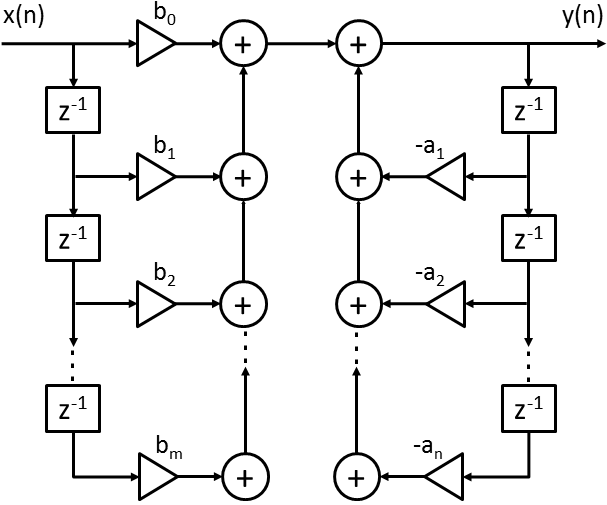

In [39]:
image_path = 'images/iir.png'
display(Image(image_path, width=800))

### 2.4 Comparación cuantitativa FIR vs IIR

| Aspecto | FIR | IIR |
|---------|-----|-----|
| Estabilidad | Siempre estable | Requiere verificación |
| Fase lineal | Sí (con simetría) | No (excepto filtfilt) |
| Orden requerido | Alto (50-500+ taps) | Bajo (2-12 típico) |
| Memoria | M+1 muestras | N+M+1 muestras |
| Operaciones/muestra | M+1 MAC | N+M+1 MAC |
| Retardo | M/2 (constante) | Variable con frecuencia |
| Cuantización | Robusto | Sensible (polos cercanos círculo) |
| Implementación | Paralela posible | Inherentemente recursiva |

### 2.5 Criterios de selección FIR vs IIR

**Usar FIR cuando:**
- Fase lineal es crítica (audio, comunicaciones)
- Estabilidad absoluta requerida
- Implementación paralela necesaria
- Recursos computacionales abundantes

**Usar IIR cuando:**
- Eficiencia computacional prioritaria
- Transiciones muy abruptas requeridas
- Memoria limitada
- Compatibilidad con diseños analógicos

## 3) Análisis paramétrico: Diseño y comparación práctica

En esta sección exploraremos cómo los diferentes parámetros afectan el comportamiento de los filtros.

Parámetros base:
fs = 44100 Hz, fc = 3000 Hz, Nyquist = 22050.0 Hz
Frecuencia normalizada: fc/nyq = 0.136

=== ANÁLISIS FIR: Efecto del número de taps ===
M=21: Retardo = 10.0 muestras, Δf ≈ 4091 Hz
M=51: Retardo = 25.0 muestras, Δf ≈ 1680 Hz
M=101: Retardo = 50.0 muestras, Δf ≈ 840 Hz
M=201: Retardo = 100.0 muestras, Δf ≈ 431 Hz


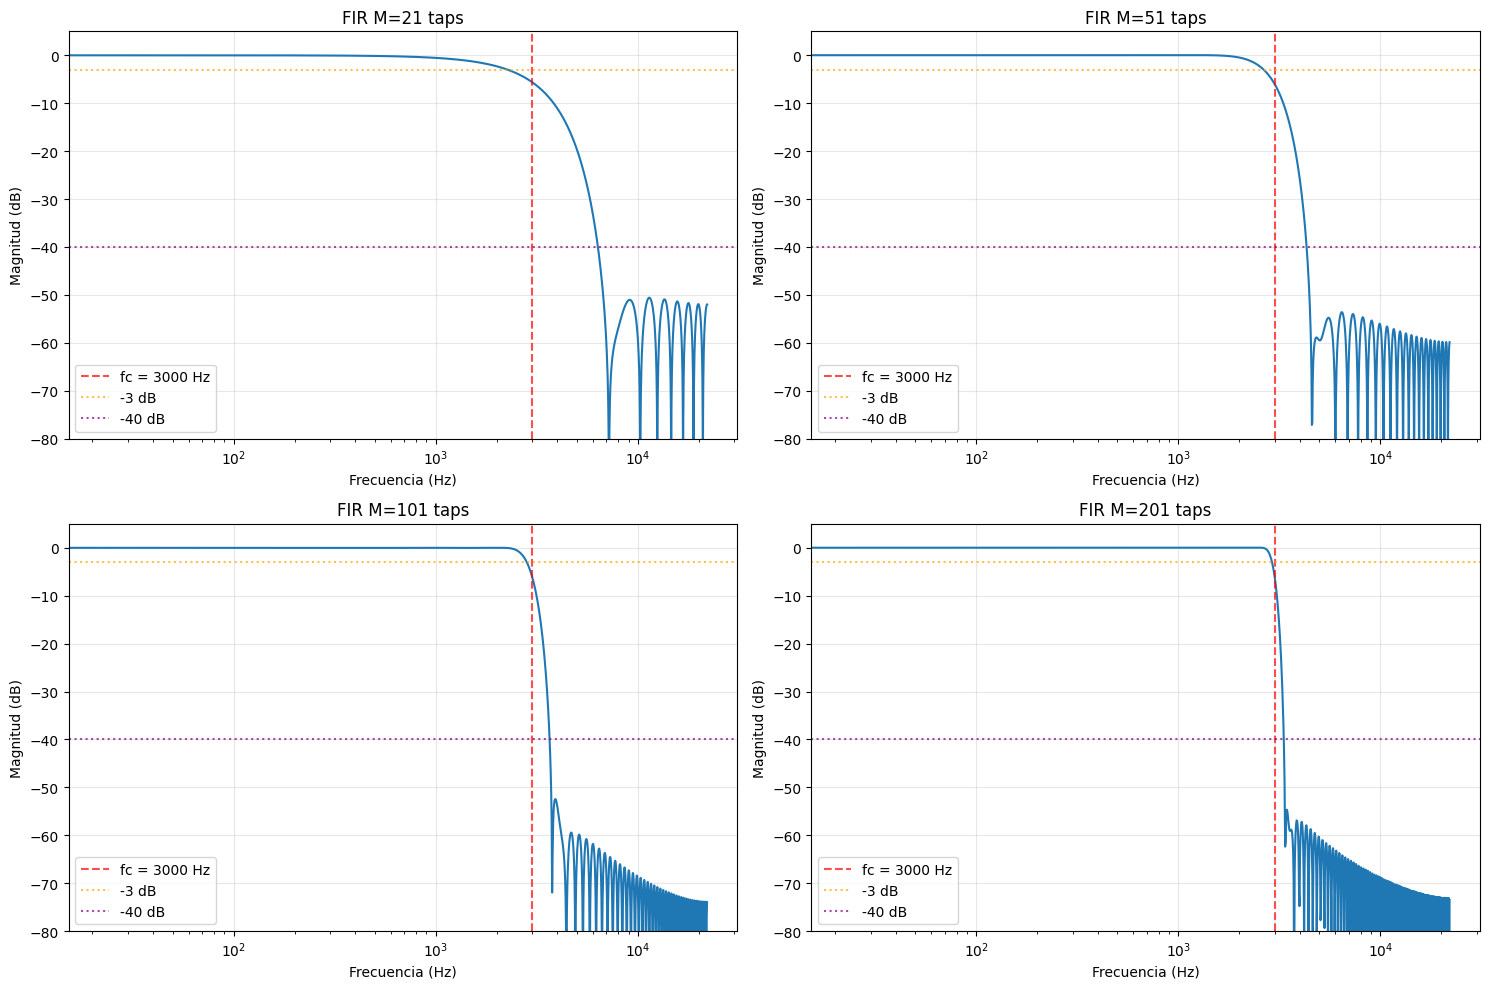

In [14]:
fs = 44100
fc = 3000
nyq = fs / 2

print(f"Parámetros base:")
print(f"fs = {fs} Hz, fc = {fc} Hz, Nyquist = {nyq} Hz")
print(f"Frecuencia normalizada: fc/nyq = {fc/nyq:.3f}")

print("\n=== ANÁLISIS FIR: Efecto del número de taps ===")

M_values = [21, 51, 101, 201]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, M in enumerate(M_values):
    h_fir = fd.design_fir_lowpass(fs, fc, num_coef=M)
    f, H = fd.freq_response_from_taps(h_fir, 1, fs=fs)

    axes[i].semilogx(f, 20*np.log10(np.abs(H)))
    axes[i].set_title(f'FIR M={M} taps')
    axes[i].set_ylabel('Magnitud (dB)')
    axes[i].set_xlabel('Frecuencia (Hz)')
    axes[i].grid(True, alpha=0.3)
    axes[i].axvline(fc, color='red', linestyle='--', alpha=0.7, label=f'fc = {fc} Hz')
    axes[i].axhline(-3, color='orange', linestyle=':', alpha=0.7, label='-3 dB')
    axes[i].axhline(-40, color='purple', linestyle=':', alpha=0.7, label='-40 dB')
    axes[i].set_ylim([-80, 5])
    axes[i].legend()

    # Calcular ancho de transición (entre -3dB y -40dB)
    mag_db = 20*np.log10(np.abs(H))
    idx_3db = np.argmin(np.abs(mag_db + 3))
    idx_40db = np.argmin(np.abs(mag_db + 40))
    transition_width = f[idx_40db] - f[idx_3db]

    print(f"M={M}: Retardo = {(M-1)/2:.1f} muestras, Δf ≈ {transition_width:.0f} Hz")

plt.tight_layout()
plt.show()

Orden 2: Pendiente teórica = -40 dB/década
Orden 4: Pendiente teórica = -80 dB/década
Orden 6: Pendiente teórica = -120 dB/década
Orden 8: Pendiente teórica = -160 dB/década


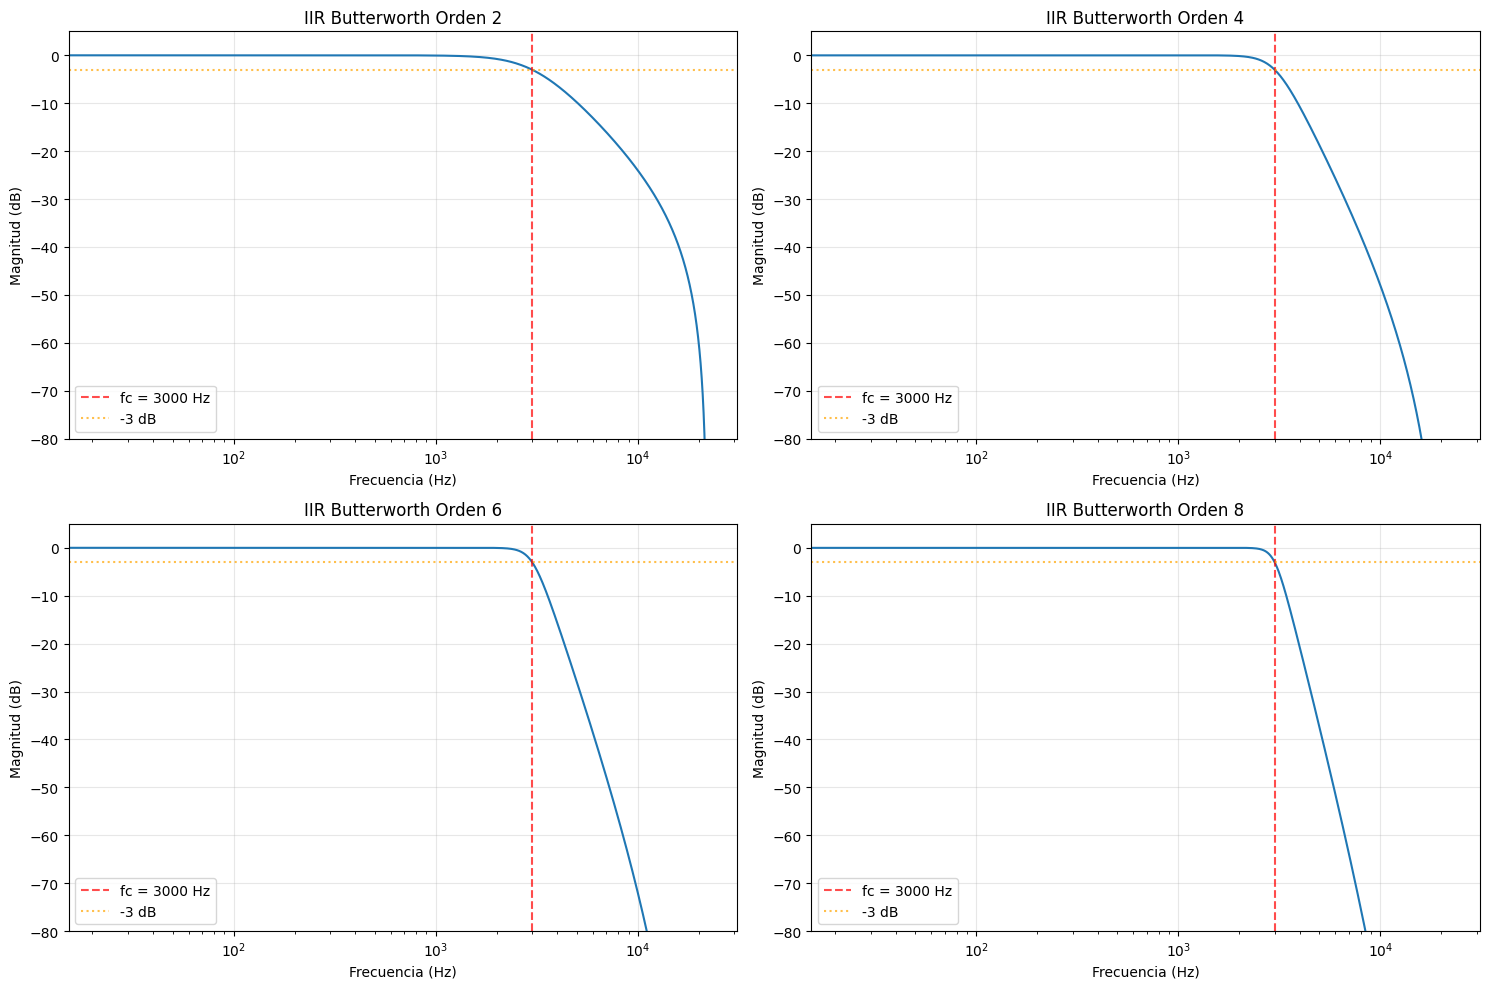

In [15]:
orders = [2, 4, 6, 8]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, order in enumerate(orders):
    b, a = fd.design_iir_butter_lowpass(fs, fc, order=order)
    f, H = fd.freq_response_from_taps(b, a, fs=fs)

    axes[i].semilogx(f, 20*np.log10(np.abs(H)))
    axes[i].set_title(f'IIR Butterworth Orden {order}')
    axes[i].set_ylabel('Magnitud (dB)')
    axes[i].set_xlabel('Frecuencia (Hz)')
    axes[i].grid(True, alpha=0.3)
    axes[i].axvline(fc, color='red', linestyle='--', alpha=0.7, label=f'fc = {fc} Hz')
    axes[i].axhline(-3, color='orange', linestyle=':', alpha=0.7, label='-3 dB')
    axes[i].set_ylim([-80, 5])
    axes[i].legend()

    mag_db = 20*np.log10(np.abs(H))
    mask = (mag_db > -60) & (mag_db < -20) & (f > fc)
    if np.any(mask):
        f_slope = f[mask]
        mag_slope = mag_db[mask]
        teorica = -20 * order
        print(f"Orden {order}: Pendiente teórica = {teorica} dB/década")

plt.tight_layout()
plt.show()

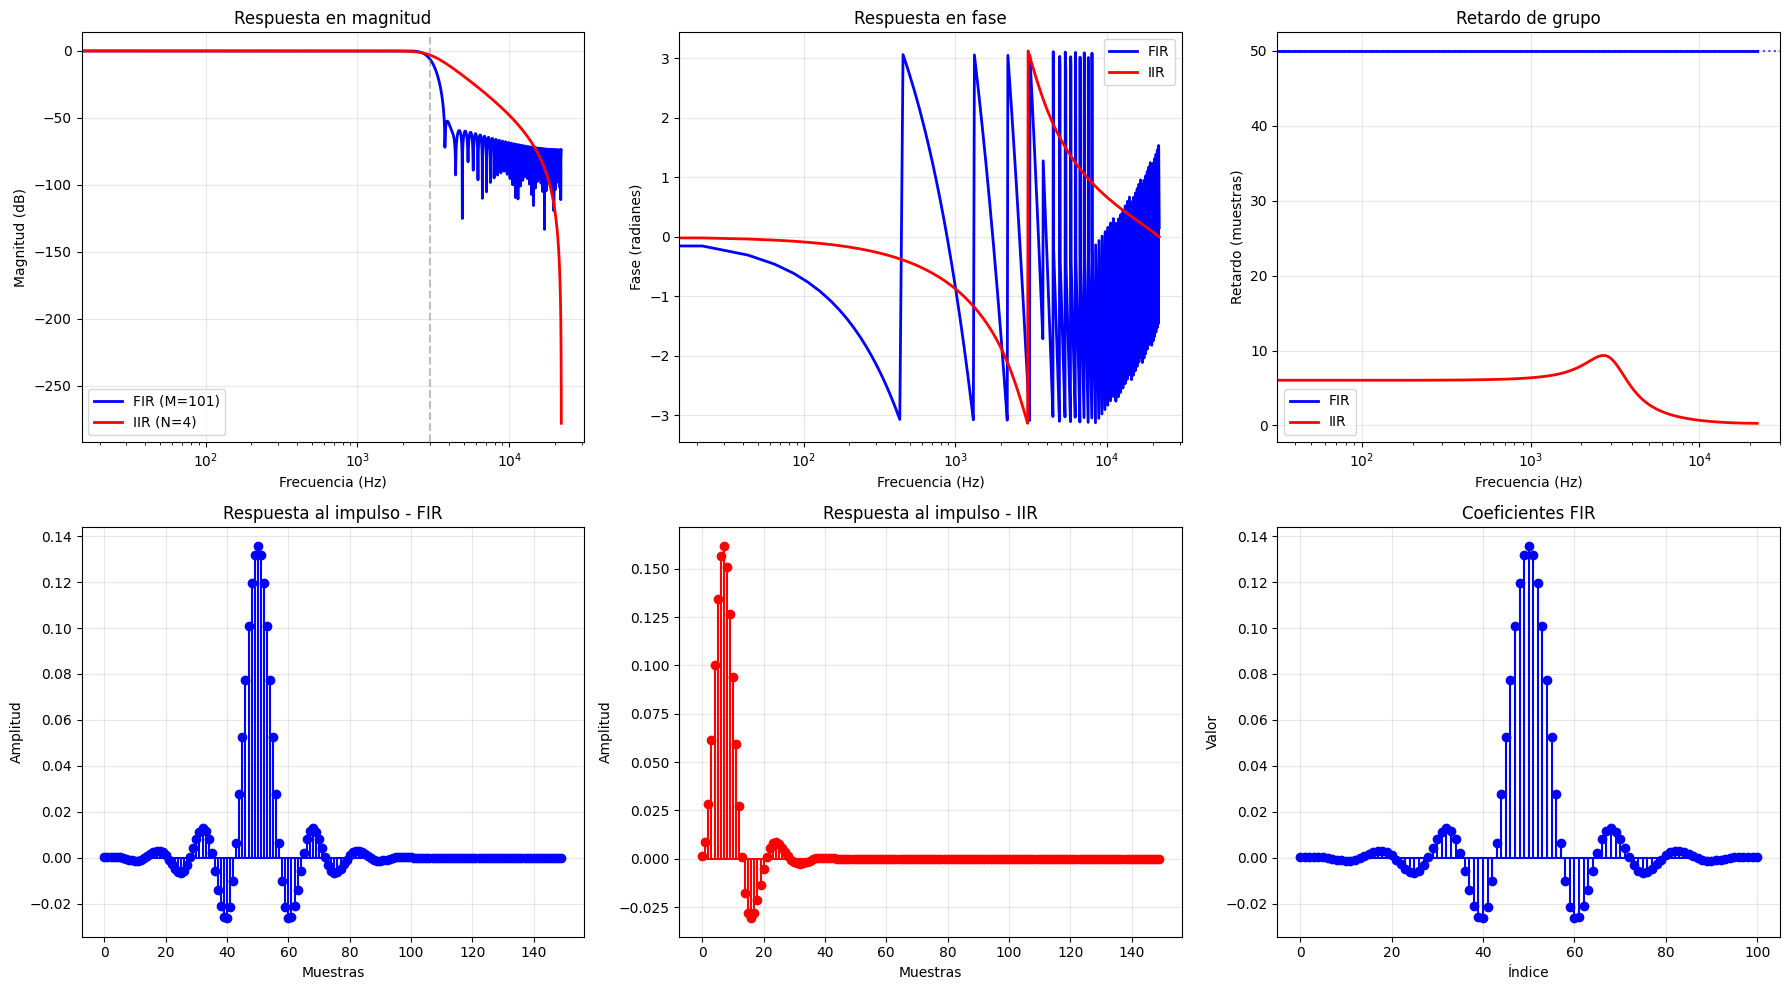

In [16]:
h_fir_101 = fd.design_fir_lowpass(fs, fc, num_coef=101)
b_iir_4, a_iir_4 = fd.design_iir_butter_lowpass(fs, fc, order=4)

f_fir, H_fir = fd.freq_response_from_taps(h_fir_101, 1, fs=fs)
f_iir, H_iir = fd.freq_response_from_taps(b_iir_4, a_iir_4, fs=fs)

w_fir, gd_fir = signal.group_delay((h_fir_101, 1), fs=fs)
w_iir, gd_iir = signal.group_delay((b_iir_4, a_iir_4), fs=fs)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0,0].semilogx(f_fir, 20*np.log10(np.abs(H_fir)), 'b-', label='FIR (M=101)', linewidth=2)
axes[0,0].semilogx(f_iir, 20*np.log10(np.abs(H_iir)), 'r-', label='IIR (N=4)', linewidth=2)
axes[0,0].set_title('Respuesta en magnitud')
axes[0,0].set_ylabel('Magnitud (dB)')
axes[0,0].set_xlabel('Frecuencia (Hz)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()
axes[0,0].axvline(fc, color='gray', linestyle='--', alpha=0.5)

axes[0,1].semilogx(f_fir, np.angle(H_fir), 'b-', label='FIR', linewidth=2)
axes[0,1].semilogx(f_iir, np.angle(H_iir), 'r-', label='IIR', linewidth=2)
axes[0,1].set_title('Respuesta en fase')
axes[0,1].set_ylabel('Fase (radianes)')
axes[0,1].set_xlabel('Frecuencia (Hz)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

axes[0,2].semilogx(w_fir, gd_fir, 'b-', label='FIR', linewidth=2)
axes[0,2].semilogx(w_iir, gd_iir, 'r-', label='IIR', linewidth=2)
axes[0,2].set_title('Retardo de grupo')
axes[0,2].set_ylabel('Retardo (muestras)')
axes[0,2].set_xlabel('Frecuencia (Hz)')
axes[0,2].grid(True, alpha=0.3)
axes[0,2].legend()
axes[0,2].axhline(50, color='blue', linestyle=':', alpha=0.7, label='50 muestras (FIR teórico)')

impulso = np.zeros(200)
impulso[0] = 1.0
resp_fir = fd.apply_fir(h_fir_101, impulso)
resp_iir = fd.apply_iir(b_iir_4, a_iir_4, impulso)

axes[1,0].stem(resp_fir[:150], linefmt='b-', markerfmt='bo', basefmt='b-', label='FIR')
axes[1,0].set_title('Respuesta al impulso - FIR')
axes[1,0].set_ylabel('Amplitud')
axes[1,0].set_xlabel('Muestras')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].stem(resp_iir[:150], linefmt='r-', markerfmt='ro', basefmt='r-', label='IIR')
axes[1,1].set_title('Respuesta al impulso - IIR')
axes[1,1].set_ylabel('Amplitud')
axes[1,1].set_xlabel('Muestras')
axes[1,1].grid(True, alpha=0.3)

axes[1,2].stem(h_fir_101, linefmt='b-', markerfmt='bo', basefmt='b-')
axes[1,2].set_title('Coeficientes FIR')
axes[1,2].set_ylabel('Valor')
axes[1,2].set_xlabel('Índice')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
print("RESUMEN COMPARATIVO:")
print("==================")
print(f"FIR (M=101):")
print(f"  - Coeficientes: {len(h_fir_101)}")
print(f"  - Retardo: {(len(h_fir_101)-1)/2:.1f} muestras")
print(f"  - Multiplicaciones por muestra: {len(h_fir_101)}")
print(f"  - Memoria: {len(h_fir_101)} muestras")

print(f"\nIIR (Orden 4):")
print(f"  - Coeficientes b: {len(b_iir_4)}")
print(f"  - Coeficientes a: {len(a_iir_4)}")
print(f"  - Multiplicaciones por muestra: {len(b_iir_4) + len(a_iir_4) - 1}")
print(f"  - Memoria: {max(len(b_iir_4), len(a_iir_4))} muestras")

# Verificar estabilidad IIR
polos = np.roots(a_iir_4)
estable = np.all(np.abs(polos) < 1.0)
print(f"  - Estabilidad: {'Estable' if estable else 'INESTABLE'}")
print(f"  - Polos: {np.abs(polos)}")

RESUMEN COMPARATIVO:
FIR (M=101):
  - Coeficientes: 101
  - Retardo: 50.0 muestras
  - Multiplicaciones por muestra: 101
  - Memoria: 101 muestras

IIR (Orden 4):
  - Coeficientes b: 5
  - Coeficientes a: 5
  - Multiplicaciones por muestra: 9
  - Memoria: 5 muestras
  - Estabilidad: Estable
  - Polos: [0.85215628 0.85215628 0.66794894 0.66794894]


In [19]:
print('Longitud FIR (debe ser num_coef):', len(h_fir_101))
print('Orden IIR aproximado (len(b)-1):', len(b_iir_4)-1)
assert len(h_fir_101) == 101, 'num_coef esperado 101'
assert (len(b_iir_4)-1) == 4, 'orden IIR esperado 4'
print('Comprobaciones básicas: OK')

Longitud FIR (debe ser num_coef): 101
Orden IIR aproximado (len(b)-1): 4
Comprobaciones básicas: OK


### 3.2 Análisis de ventanas FIR y sus parámetros

=== ANÁLISIS DE VENTANAS FIR ===

Ventana hamming:
  Ripple banda paso: 5.899 dB
  Atenuación rechazo: 59.4 dB
  Teórico ripple: 0.0194
  Teórico atenuación: 53 dB

Ventana hann:
  Ripple banda paso: 5.941 dB
  Atenuación rechazo: 62.1 dB
  Teórico ripple: 0.0063
  Teórico atenuación: 44 dB

Ventana blackman:
  Ripple banda paso: 5.909 dB
  Atenuación rechazo: 75.3 dB
  Teórico ripple: 0.0002
  Teórico atenuación: 74 dB


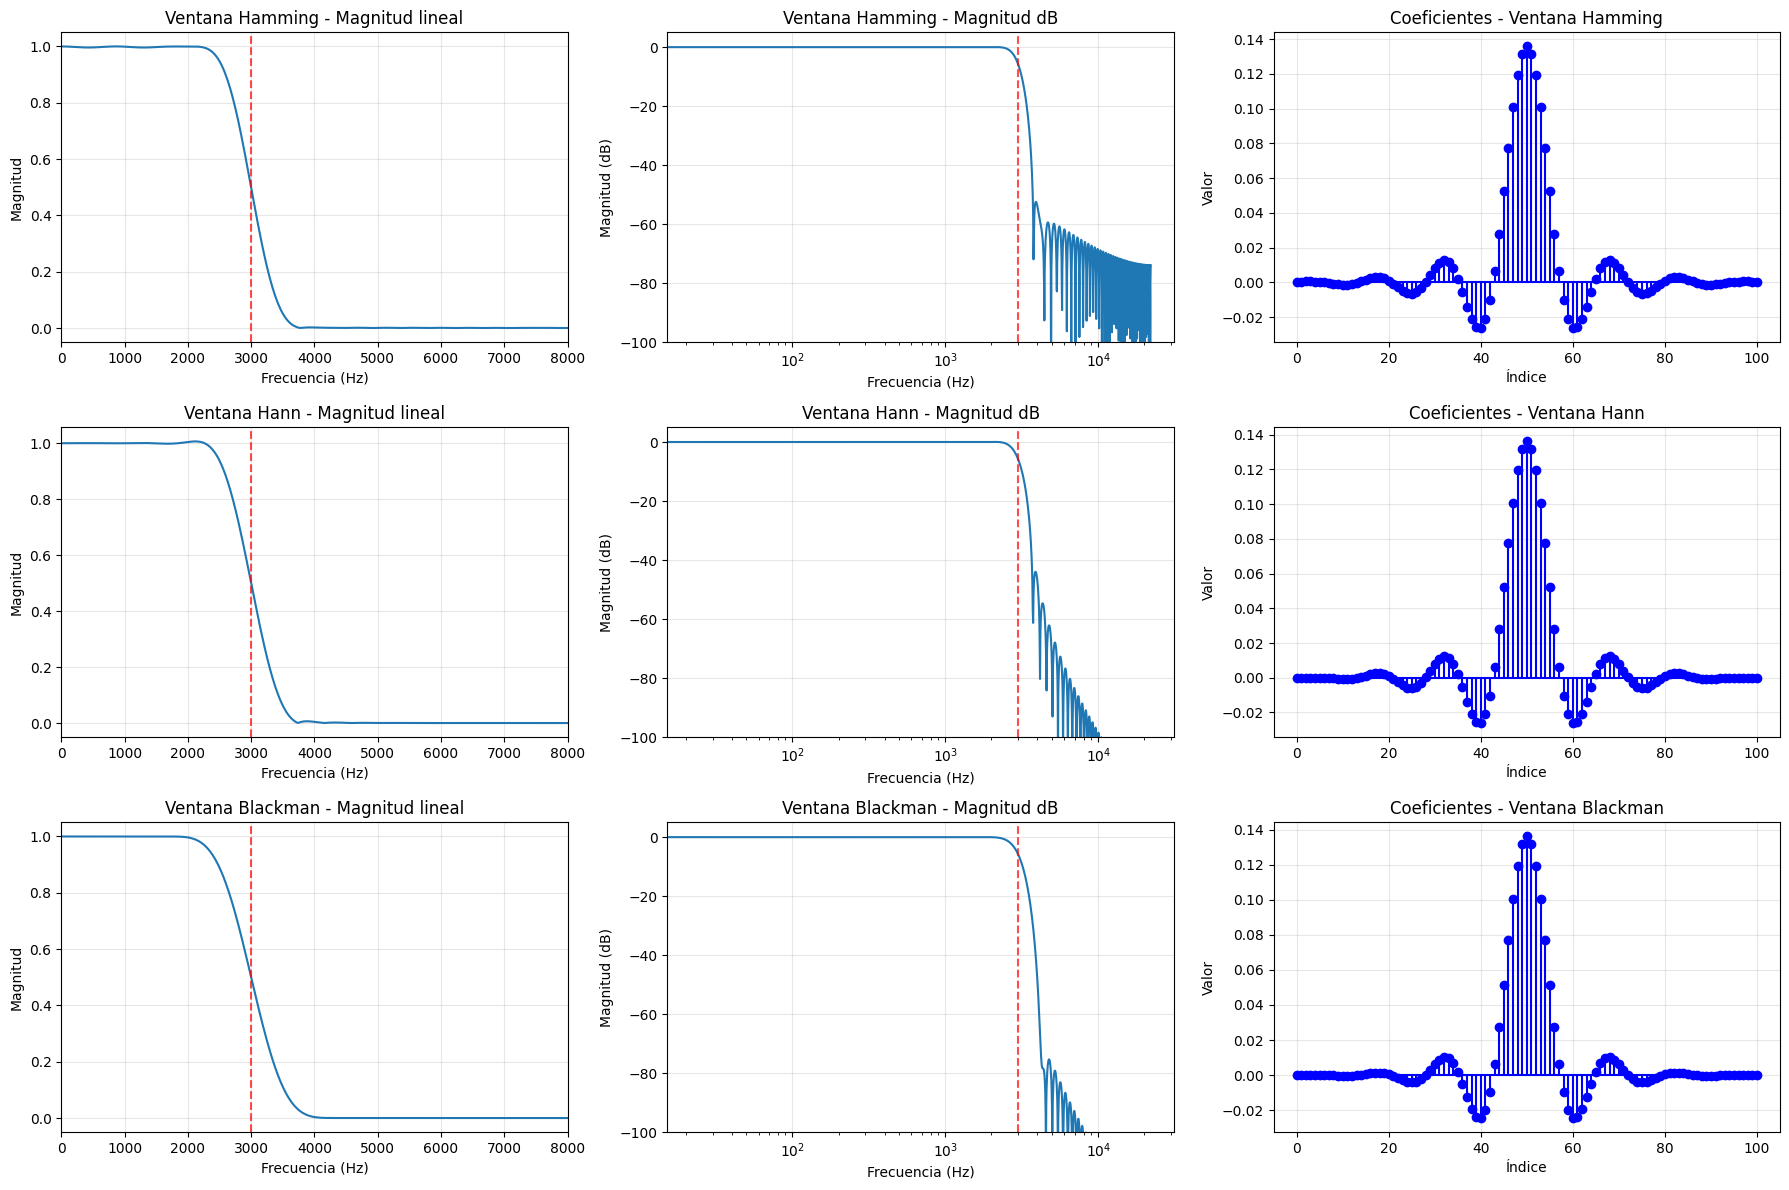

In [20]:
ventanas_info = {
    'hamming': {'ripple_paso': 0.0194, 'atenua_rechazo': 53, 'ancho_norm': 3.3},
    'hann': {'ripple_paso': 0.0063, 'atenua_rechazo': 44, 'ancho_norm': 3.1},
    'blackman': {'ripple_paso': 0.0002, 'atenua_rechazo': 74, 'ancho_norm': 5.5},
    'kaiser_5': {'ripple_paso': 0.001, 'atenua_rechazo': 50, 'ancho_norm': 4.0},
    'kaiser_8': {'ripple_paso': 0.0001, 'atenua_rechazo': 70, 'ancho_norm': 5.0}
}

ventanas = ['hamming', 'hann', 'blackman']
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

M = 101

for i, ventana in enumerate(ventanas):
    if ventana == 'kaiser_5':
        h = fd.design_fir_lowpass(fs, fc, num_coef=M, window=('kaiser', 5))
    elif ventana == 'kaiser_8':
        h = fd.design_fir_lowpass(fs, fc, num_coef=M, window=('kaiser', 8))
    else:
        h = fd.design_fir_lowpass(fs, fc, num_coef=M, window=ventana)

    f, H = fd.freq_response_from_taps(h, 1, fs=fs)

    axes[i,0].plot(f, np.abs(H))
    axes[i,0].set_title(f'Ventana {ventana.capitalize()} - Magnitud lineal')
    axes[i,0].set_ylabel('Magnitud')
    axes[i,0].set_xlabel('Frecuencia (Hz)')
    axes[i,0].grid(True, alpha=0.3)
    axes[i,0].axvline(fc, color='red', linestyle='--', alpha=0.7)
    axes[i,0].set_xlim([0, 8000])

    axes[i,1].semilogx(f, 20*np.log10(np.abs(H)))
    axes[i,1].set_title(f'Ventana {ventana.capitalize()} - Magnitud dB')
    axes[i,1].set_ylabel('Magnitud (dB)')
    axes[i,1].set_xlabel('Frecuencia (Hz)')
    axes[i,1].grid(True, alpha=0.3)
    axes[i,1].axvline(fc, color='red', linestyle='--', alpha=0.7)
    axes[i,1].set_ylim([-100, 5])

    axes[i,2].stem(h, linefmt='b-', markerfmt='bo', basefmt='b-')
    axes[i,2].set_title(f'Coeficientes - Ventana {ventana.capitalize()}')
    axes[i,2].set_ylabel('Valor')
    axes[i,2].set_xlabel('Índice')
    axes[i,2].grid(True, alpha=0.3)

    mag_db = 20*np.log10(np.abs(H))

    idx_paso = f <= fc
    if np.any(idx_paso):
        ripple_paso = np.max(mag_db[idx_paso]) - np.min(mag_db[idx_paso])
    else:
        ripple_paso = 0

    idx_rechazo = f >= 1.5*fc
    if np.any(idx_rechazo):
        aten_rechazo = -np.max(mag_db[idx_rechazo])
    else:
        aten_rechazo = 0

    print(f"\nVentana {ventana}:")
    print(f"  Ripple banda paso: {ripple_paso:.3f} dB")
    print(f"  Atenuación rechazo: {aten_rechazo:.1f} dB")
    info = ventanas_info.get(ventana, {})
    print(f"  Teórico ripple: {info.get('ripple_paso', 'N/A')}")
    print(f"  Teórico atenuación: {info.get('atenua_rechazo', 'N/A')} dB")

plt.tight_layout()
plt.show()

Kaiser β=2: Δf ≈ 366 Hz, Atenuación ≈ 41.2 dB
Kaiser β=5: Δf ≈ 646 Hz, Atenuación ≈ 62.1 dB
Kaiser β=8: Δf ≈ 861 Hz, Atenuación ≈ 83.4 dB
Kaiser β=12: Δf ≈ 1077 Hz, Atenuación ≈ 75.0 dB


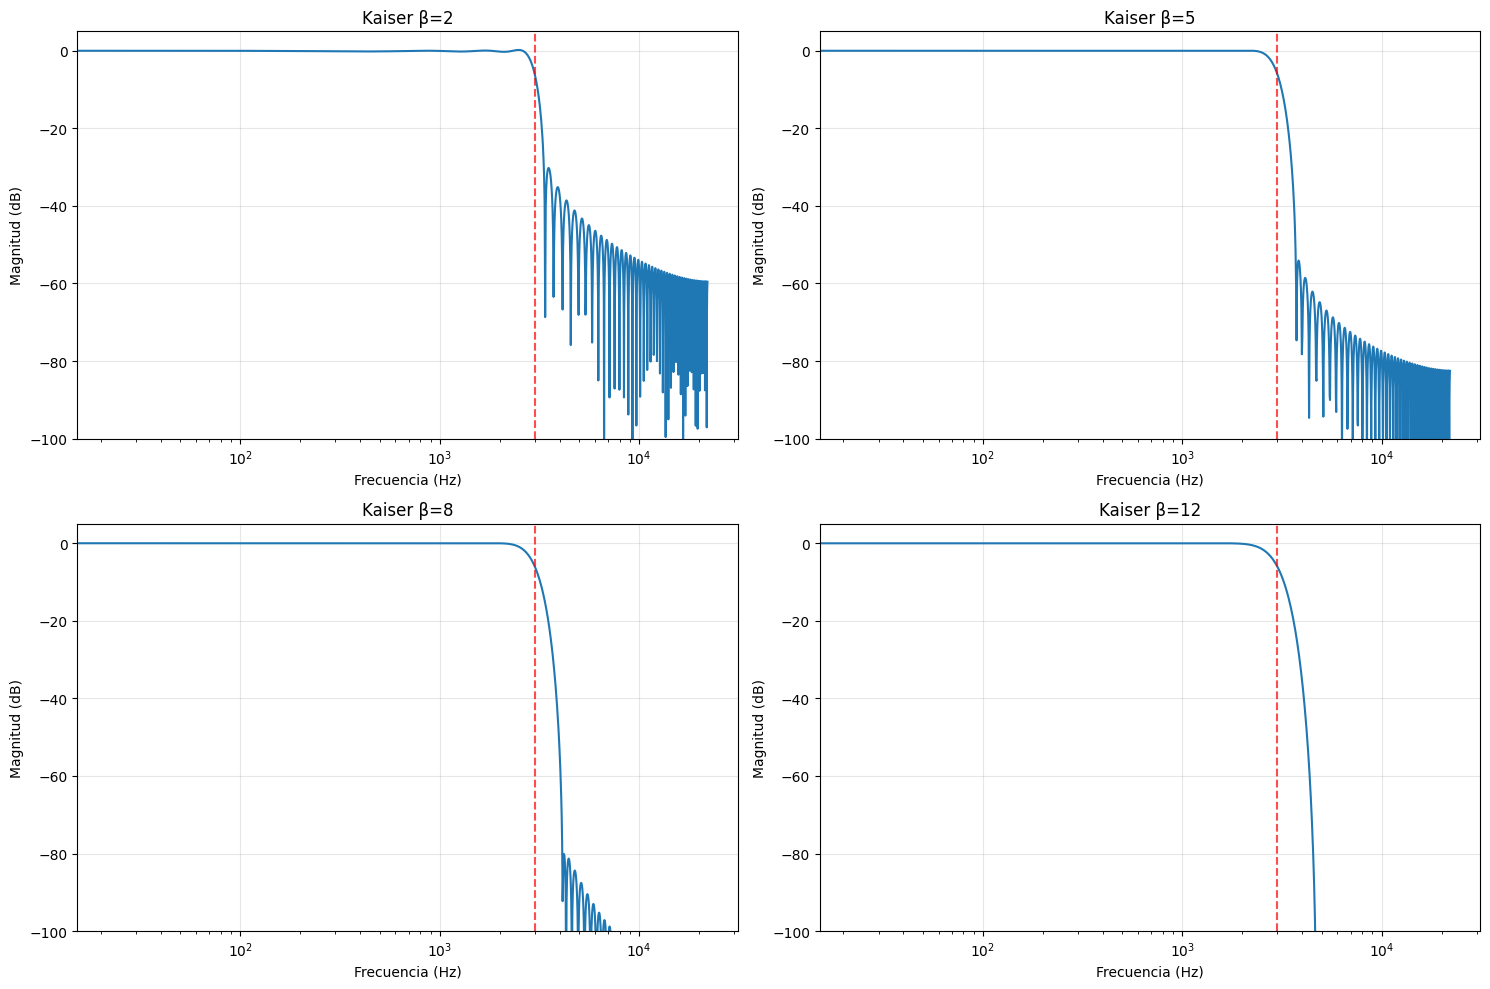

In [22]:
betas = [2, 5, 8, 12]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, beta in enumerate(betas):
    h_kaiser = fd.design_fir_lowpass(fs, fc, num_coef=M, window=('kaiser', beta))
    f, H = fd.freq_response_from_taps(h_kaiser, 1, fs=fs)

    axes[i].semilogx(f, 20*np.log10(np.abs(H)))
    axes[i].set_title(f'Kaiser β={beta}')
    axes[i].set_ylabel('Magnitud (dB)')
    axes[i].set_xlabel('Frecuencia (Hz)')
    axes[i].grid(True, alpha=0.3)
    axes[i].axvline(fc, color='red', linestyle='--', alpha=0.7)
    axes[i].set_ylim([-100, 5])

    mag_db = 20*np.log10(np.abs(H))

    try:
        idx_3db = np.where((f > fc) & (mag_db <= -3))[0][0]
        idx_40db = np.where((f > fc) & (mag_db <= -40))[0][0]
        ancho_trans = f[idx_40db] - f[idx_3db]
    except:
        ancho_trans = np.nan

    idx_stop = f >= 1.5*fc
    if np.any(idx_stop):
        aten_stop = -np.max(mag_db[idx_stop])
    else:
        aten_stop = np.nan

    print(f"Kaiser β={beta}: Δf ≈ {ancho_trans:.0f} Hz, Atenuación ≈ {aten_stop:.1f} dB")

plt.tight_layout()
plt.show()

### 3.3 Análisis de tipos IIR y sus parámetros característicos

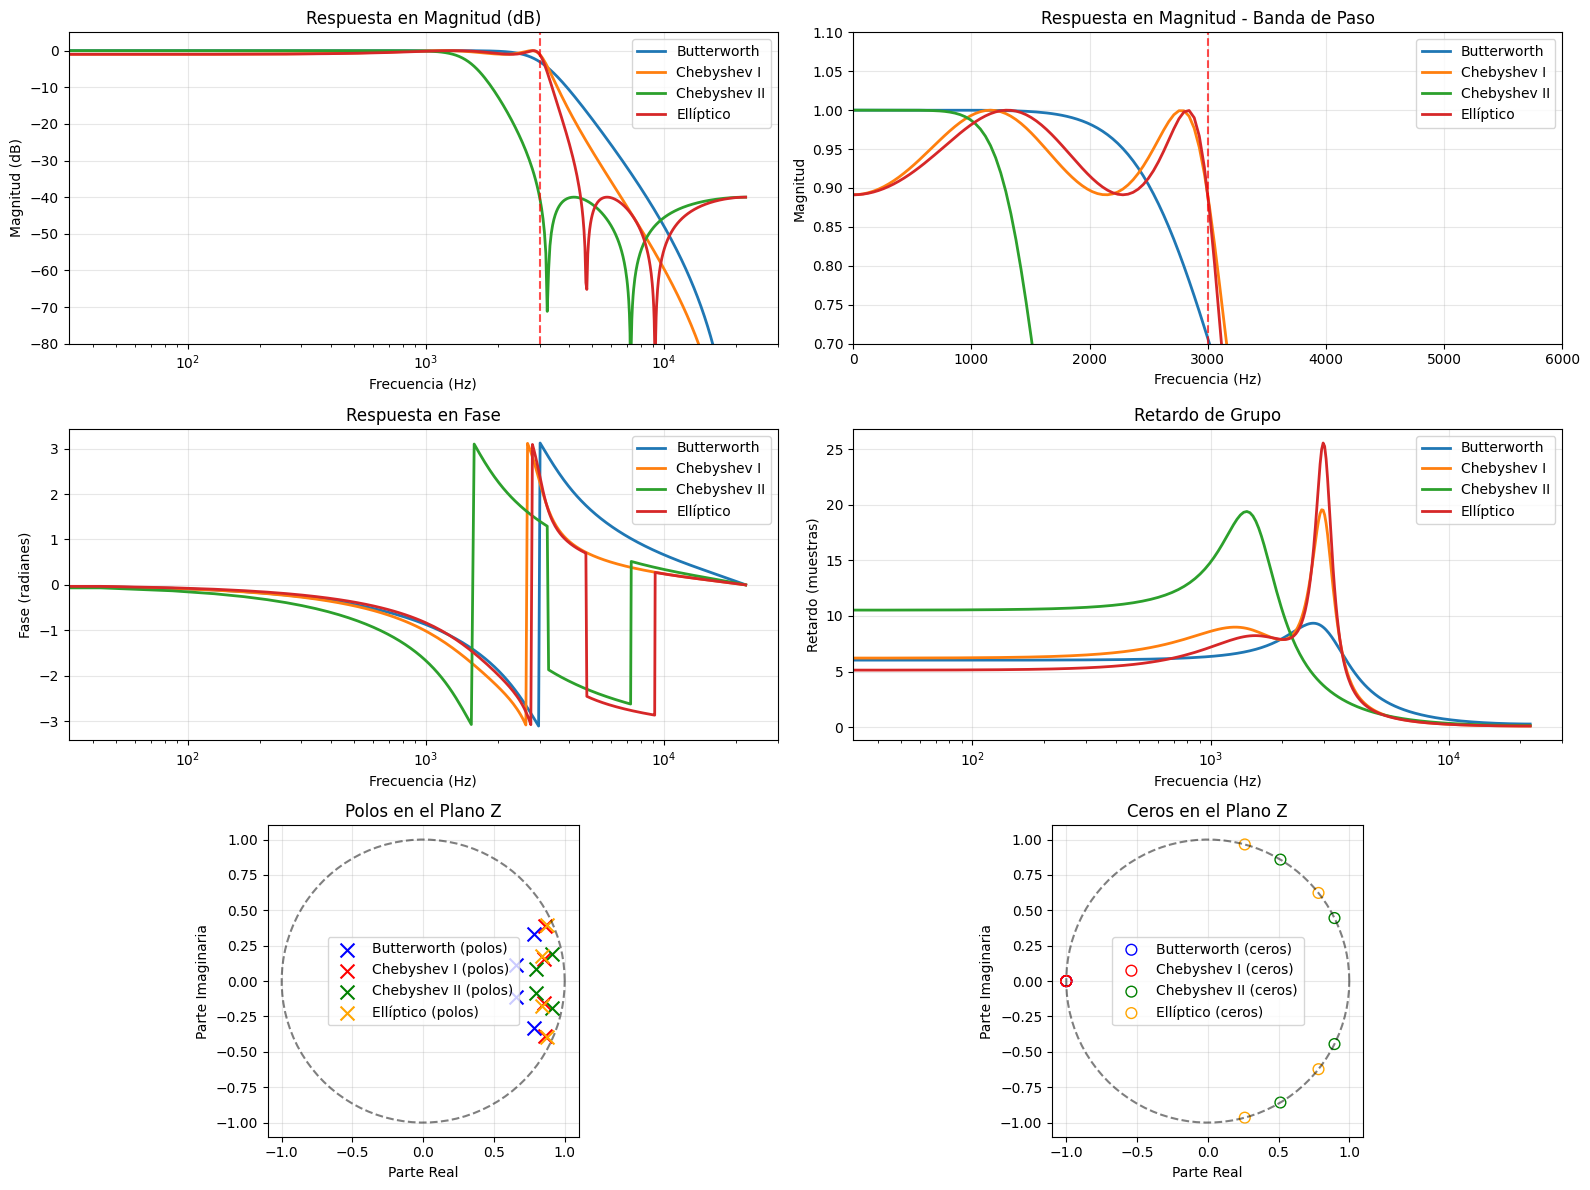

In [ ]:
from scipy.signal import butter, cheby1, cheby2, ellip

orden = 4
fc_norm = fc / nyq
Rp = 1
Rs = 40

filtros_iir = {}

b_butter, a_butter = butter(orden, fc_norm, btype='low')
filtros_iir['Butterworth'] = (b_butter, a_butter)

b_cheby1, a_cheby1 = cheby1(orden, Rp, fc_norm, btype='low')
filtros_iir['Chebyshev I'] = (b_cheby1, a_cheby1)

b_cheby2, a_cheby2 = cheby2(orden, Rs, fc_norm, btype='low')
filtros_iir['Chebyshev II'] = (b_cheby2, a_cheby2)

b_ellip, a_ellip = ellip(orden, Rp, Rs, fc_norm, btype='low')
filtros_iir['Ellíptico'] = (b_ellip, a_ellip)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for nombre, (b, a) in filtros_iir.items():
    f, H = signal.freqz(b, a, fs=fs)

    axes[0,0].semilogx(f, 20*np.log10(np.abs(H)), label=nombre, linewidth=2)

    axes[0,1].plot(f, np.abs(H), label=nombre, linewidth=2)

axes[0,0].set_title('Respuesta en Magnitud (dB)')
axes[0,0].set_ylabel('Magnitud (dB)')
axes[0,0].set_xlabel('Frecuencia (Hz)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()
axes[0,0].axvline(fc, color='red', linestyle='--', alpha=0.7)
axes[0,0].set_ylim([-80, 5])

axes[0,1].set_title('Respuesta en Magnitud - Banda de Paso')
axes[0,1].set_ylabel('Magnitud')
axes[0,1].set_xlabel('Frecuencia (Hz)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()
axes[0,1].axvline(fc, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_xlim([0, fc*2])
axes[0,1].set_ylim([0.7, 1.1])

for nombre, (b, a) in filtros_iir.items():
    f, H = signal.freqz(b, a, fs=fs)
    w, gd = signal.group_delay((b, a), fs=fs)

    axes[1,0].semilogx(f, np.angle(H), label=nombre, linewidth=2)

    axes[1,1].semilogx(w, gd, label=nombre, linewidth=2)

axes[1,0].set_title('Respuesta en Fase')
axes[1,0].set_ylabel('Fase (radianes)')
axes[1,0].set_xlabel('Frecuencia (Hz)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

axes[1,1].set_title('Retardo de Grupo')
axes[1,1].set_ylabel('Retardo (muestras)')
axes[1,1].set_xlabel('Frecuencia (Hz)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

colors = ['blue', 'red', 'green', 'orange']
for i, (nombre, (b, a)) in enumerate(filtros_iir.items()):
    ceros = np.roots(b)
    polos = np.roots(a)

    color = colors[i]

    axes[2,0].scatter(np.real(polos), np.imag(polos),
                     marker='x', s=100, color=color, label=f'{nombre} (polos)')

    if len(ceros) > 0:
        axes[2,1].scatter(np.real(ceros), np.imag(ceros),
                         marker='o', s=60, facecolors='none',
                         edgecolors=color, label=f'{nombre} (ceros)')

theta = np.linspace(0, 2*np.pi, 100)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

axes[2,0].plot(circle_x, circle_y, 'k--', alpha=0.5)
axes[2,0].set_title('Polos en el Plano Z')
axes[2,0].set_xlabel('Parte Real')
axes[2,0].set_ylabel('Parte Imaginaria')
axes[2,0].grid(True, alpha=0.3)
axes[2,0].legend()
axes[2,0].set_aspect('equal')

axes[2,1].plot(circle_x, circle_y, 'k--', alpha=0.5)
axes[2,1].set_title('Ceros en el Plano Z')
axes[2,1].set_xlabel('Parte Real')
axes[2,1].set_ylabel('Parte Imaginaria')
axes[2,1].grid(True, alpha=0.3)
axes[2,1].legend()
axes[2,1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [25]:
for nombre, (b, a) in filtros_iir.items():
    f, H = signal.freqz(b, a, fs=fs)
    mag_db = 20*np.log10(np.abs(H))

    idx_paso = f <= fc
    if np.any(idx_paso):
        max_paso = np.max(mag_db[idx_paso])
        min_paso = np.min(mag_db[idx_paso])
        ripple_paso = max_paso - min_paso
    else:
        ripple_paso = 0

    idx_3db = np.argmin(np.abs(mag_db + 3))
    f_3db = f[idx_3db]

    idx_rechazo = f >= 1.5*fc
    if np.any(idx_rechazo):
        aten_rechazo = -np.max(mag_db[idx_rechazo])
    else:
        aten_rechazo = 0

    polos = np.roots(a)
    max_polo = np.max(np.abs(polos))
    estable = max_polo < 1.0

    print(f"\n{nombre}:")
    print(f"  Coeficientes b: {len(b)}, a: {len(a)}")
    print(f"  Ripple banda paso: {ripple_paso:.3f} dB")
    print(f"  Frecuencia -3dB: {f_3db:.0f} Hz")
    print(f"  Atenuación rechazo: {aten_rechazo:.1f} dB")
    print(f"  Polo máximo: {max_polo:.4f}")
    print(f"  Estabilidad: {'Estable' if estable else 'INESTABLE'}")

    if nombre == 'Chebyshev I':
        print(f"  Ripple especificado: {Rp} dB")
    elif nombre == 'Chebyshev II':
        print(f"  Atenuación especificada: {Rs} dB")
    elif nombre == 'Ellíptico':
        print(f"  Ripple especificado: {Rp} dB")
        print(f"  Atenuación especificada: {Rs} dB")


Butterworth:
  Coeficientes b: 5, a: 5
  Ripple banda paso: 2.843 dB
  Frecuencia -3dB: 3015 Hz
  Atenuación rechazo: 15.1 dB
  Polo máximo: 0.8522
  Estabilidad: Estable

Chebyshev I:
  Coeficientes b: 5, a: 5
  Ripple banda paso: 1.000 dB
  Frecuencia -3dB: 3144 Hz
  Atenuación rechazo: 22.7 dB
  Polo máximo: 0.9437
  Estabilidad: Estable
  Ripple especificado: 1 dB

Chebyshev II:
  Coeficientes b: 5, a: 5
  Ripple banda paso: 38.699 dB
  Frecuencia -3dB: 1507 Hz
  Atenuación rechazo: 40.0 dB
  Polo máximo: 0.9291
  Estabilidad: Estable
  Atenuación especificada: 40 dB

Ellíptico:
  Coeficientes b: 5, a: 5
  Ripple banda paso: 1.000 dB
  Frecuencia -3dB: 3101 Hz
  Atenuación rechazo: 40.0 dB
  Polo máximo: 0.9573
  Estabilidad: Estable
  Ripple especificado: 1 dB
  Atenuación especificada: 40 dB


## 4) Aplicación práctica: Efectos de parámetros en señales reales

Ahora verificaremos cómo los diferentes parámetros de filtros afectan señales de audio reales, observando la relación entre teoría y práctica.

In [27]:
try:
    filename = 'recording_1.wav'
    x, sr = sf.read(filename)
    print(f'Archivo leído: {filename}, fs={sr} Hz, forma={x.shape}')

    if x.ndim > 1:
        x = np.mean(x, axis=1)
        print('Convertido a mono')

    x = x / np.max(np.abs(x))

except Exception as e:
    sr = 44100
    t = np.linspace(0, 2, int(sr*2))
    x = np.sin(2*np.pi*440*t) + 0.3*np.sin(2*np.pi*8000*t) + 0.1*np.random.randn(len(t))
    x = x / np.max(np.abs(x))

Archivo leído: recording_1.wav, fs=16000 Hz, forma=(80000,)


In [28]:
y_fir = fd.apply_fir(h_fir_101, x)
y_iir_normal = fd.apply_iir(b_iir_4, a_iir_4, x, zero_phase=False)
y_iir_zerophase = fd.apply_iir(b_iir_4, a_iir_4, x, zero_phase=True)

sf.write('audio_original.wav', x, sr)
sf.write('audio_filtrado_fir.wav', y_fir, sr)
sf.write('audio_filtrado_iir.wav', y_iir_normal, sr)
sf.write('audio_filtrado_iir_zerophase.wav', y_iir_zerophase, sr)

print('Archivos guardados para comparación auditiva')

print('Original:')
display(Audio(x, rate=sr))
print('Filtrado FIR:')
display(Audio(y_fir, rate=sr))
print('Filtrado IIR (normal):')
display(Audio(y_iir_normal, rate=sr))
print('Filtrado IIR (zero-phase):')
display(Audio(y_iir_zerophase, rate=sr))

Archivos guardados para comparación auditiva
Original:


Filtrado FIR:


Filtrado IIR (normal):


Filtrado IIR (zero-phase):


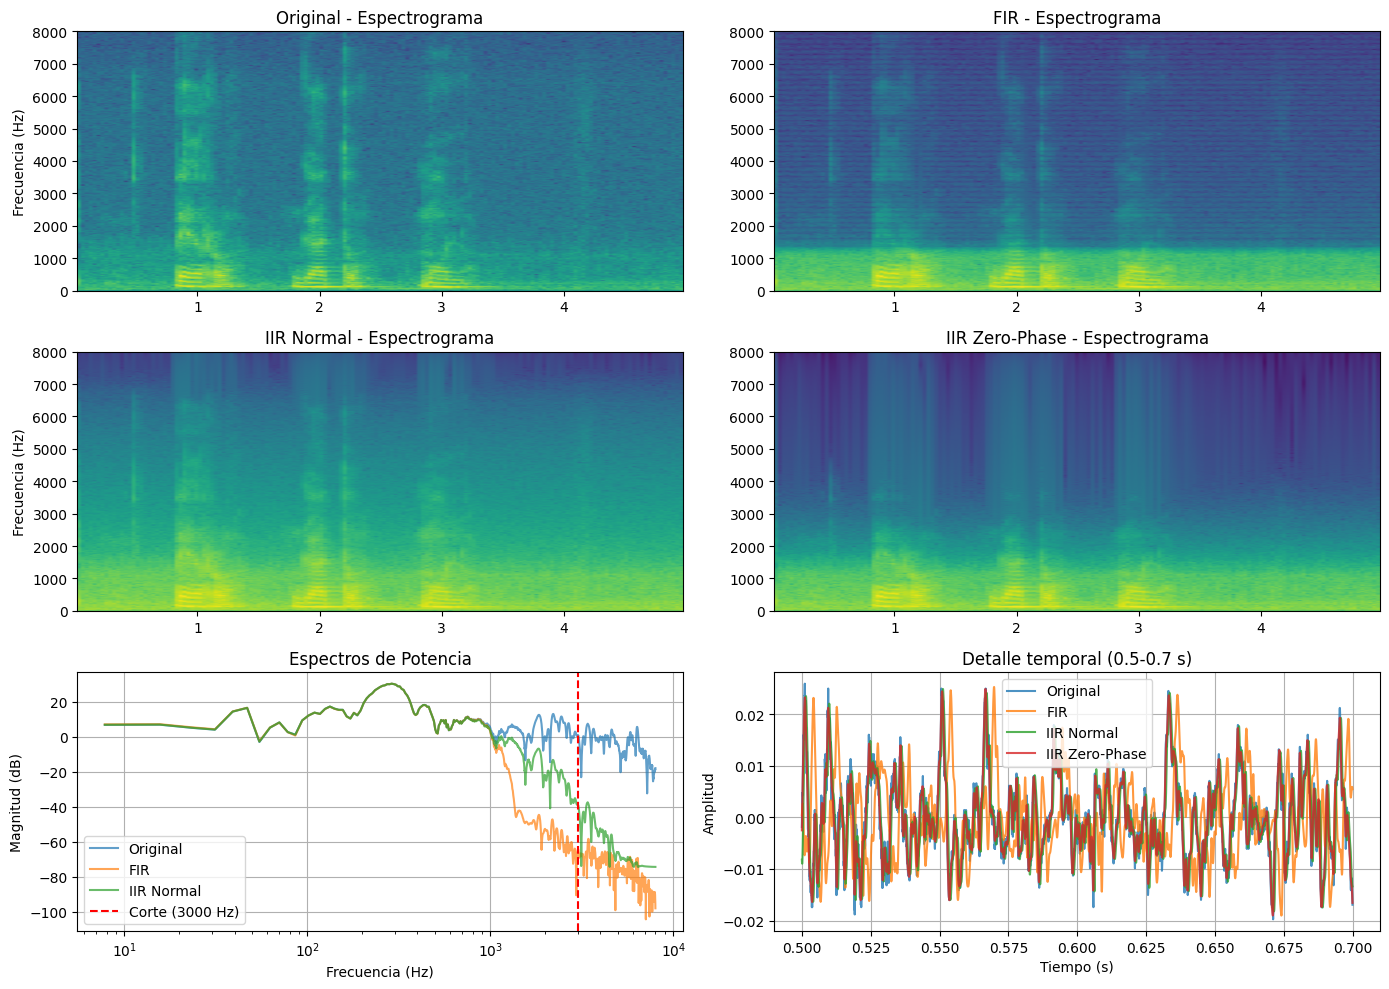

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

axes[0,0].specgram(x, NFFT=1024, Fs=sr, noverlap=512)
axes[0,0].set_title('Original - Espectrograma')
axes[0,0].set_ylabel('Frecuencia (Hz)')

axes[0,1].specgram(y_fir, NFFT=1024, Fs=sr, noverlap=512)
axes[0,1].set_title('FIR - Espectrograma')

axes[1,0].specgram(y_iir_normal, NFFT=1024, Fs=sr, noverlap=512)
axes[1,0].set_title('IIR Normal - Espectrograma')
axes[1,0].set_ylabel('Frecuencia (Hz)')

axes[1,1].specgram(y_iir_zerophase, NFFT=1024, Fs=sr, noverlap=512)
axes[1,1].set_title('IIR Zero-Phase - Espectrograma')

freqs = np.fft.fftfreq(2048, 1/sr)[:1024]
X = np.abs(np.fft.fft(x[:2048]))[:1024]
Y_fir = np.abs(np.fft.fft(y_fir[:2048]))[:1024]
Y_iir = np.abs(np.fft.fft(y_iir_normal[:2048]))[:1024]
Y_iir_zp = np.abs(np.fft.fft(y_iir_zerophase[:2048]))[:1024]

axes[2,0].semilogx(freqs[1:], 20*np.log10(X[1:]), label='Original', alpha=0.7)
axes[2,0].semilogx(freqs[1:], 20*np.log10(Y_fir[1:]), label='FIR', alpha=0.7)
axes[2,0].semilogx(freqs[1:], 20*np.log10(Y_iir[1:]), label='IIR Normal', alpha=0.7)
axes[2,0].axvline(fc, color='red', linestyle='--', label=f'Corte ({fc} Hz)')
axes[2,0].set_xlabel('Frecuencia (Hz)')
axes[2,0].set_ylabel('Magnitud (dB)')
axes[2,0].set_title('Espectros de Potencia')
axes[2,0].legend()
axes[2,0].grid(True)

n_start = int(0.5*sr)
n_end = int(0.7*sr)
t_zoom = np.arange(n_start, n_end) / sr

axes[2,1].plot(t_zoom, x[n_start:n_end], label='Original', alpha=0.8)
axes[2,1].plot(t_zoom, y_fir[n_start:n_end], label='FIR', alpha=0.8)
axes[2,1].plot(t_zoom, y_iir_normal[n_start:n_end], label='IIR Normal', alpha=0.8)
axes[2,1].plot(t_zoom, y_iir_zerophase[n_start:n_end], label='IIR Zero-Phase', alpha=0.8)
axes[2,1].set_xlabel('Tiempo (s)')
axes[2,1].set_ylabel('Amplitud')
axes[2,1].set_title('Detalle temporal (0.5-0.7 s)')
axes[2,1].legend()
axes[2,1].grid(True)

plt.tight_layout()
plt.show()

## 5) Ejercicios de análisis paramétrico

Realiza los siguientes ejercicios para consolidar la comprensión sobre parámetros de filtros:

### Ejercicio 1: Diseño óptimo FIR vs IIR para especificaciones dadas

**Especificaciones del filtro:**
- Frecuencia de paso: 0-2000 Hz (ripple máximo 0.5 dB)
- Frecuencia de rechazo: 3000+ Hz (atenuación mínima 50 dB)
- Frecuencia de muestreo: 44100 Hz

Determina el orden mínimo requerido para FIR y diferentes tipos IIR.


1. FILTRO FIR (Kaiser):
   Orden estimado M = 130
   β estimado = 4.53

2. FILTROS IIR:
   Butterworth: Orden N = 17
   Chebyshev I: Orden N = 8
   Chebyshev II: Orden N = 8
   Ellíptico: Orden N = 5

3. VERIFICACIÓN DE ESPECIFICACIONES:
FIR Kaiser:
  Coeficientes totales: 131
  Ripple paso: 5.51 dB No
  Atenuación rechazo: 58.1 dB Si
  Retardo: 65.0 muestras
  Cumple especificaciones: NO

Butterworth:
  Coeficientes totales: 35
  Ripple paso: 0.37 dB Si
  Atenuación rechazo: 52.7 dB Si
  Retardo: 35.6 muestras
  Cumple especificaciones: SÍ

Chebyshev I:
  Coeficientes totales: 17
  Ripple paso: 0.50 dB Si
  Atenuación rechazo: 53.0 dB Si
  Retardo: 22.4 muestras
  Cumple especificaciones: SÍ

Chebyshev II:
  Coeficientes totales: 17
  Ripple paso: 0.41 dB Si
  Atenuación rechazo: 50.0 dB Si
  Retardo: 10.9 muestras
  Cumple especificaciones: SÍ

Ellíptico:
  Coeficientes totales: 11
  Ripple paso: 0.50 dB Si
  Atenuación rechazo: 50.0 dB Si
  Retardo: 12.1 muestras
  Cumple especific

/var/folders/mq/1rf9bn6s6wg2bxvp1xqznkfr0000gn/T/ipykernel_75399/2816286202.py:101: UserWarning: The filter's denominator is extremely small at frequencies [0.000, 0.006, 0.012, 0.018, 0.025, 0.031, 0.037, 0.043, 0.049, 0.055, 0.061, 0.067, 0.074, 0.080, 0.086, 0.092, 0.098, 0.104, 0.110, 0.117, 0.123, 0.129, 0.135, 0.141, 0.147, 0.153, 0.160, 0.166, 0.172, 0.178, 0.184, 0.190, 0.196, 0.202, 0.209, 0.215, 0.221, 0.227, 0.233, 0.239, 0.245, 0.252, 0.258, 0.264, 0.270, 0.276, 0.282, 0.288, 0.295, 0.301, 0.307, 0.313, 0.319, 0.325, 0.331, 0.337, 0.344, 0.350, 0.356, 0.362, 0.368, 0.374, 0.380, 0.387, 0.393, 0.399, 0.405, 0.411, 0.417, 0.423, 0.430, 0.436, 0.442, 0.448, 0.454, 0.460, 0.466, 0.472, 0.479, 0.485, 0.491, 0.497, 0.503, 0.509, 0.515, 0.522, 0.528, 0.534, 0.540, 0.546, 0.552, 0.558, 0.565, 0.571, 2.571, 2.577, 2.583, 2.589, 2.595, 2.602, 2.608, 2.614, 2.620, 2.626, 2.632, 2.638, 2.645, 2.651, 2.657, 2.663, 2.669, 2.675, 2.681, 2.688, 2.694, 2.700, 2.706, 2.712, 2.718, 2.724, 2.7

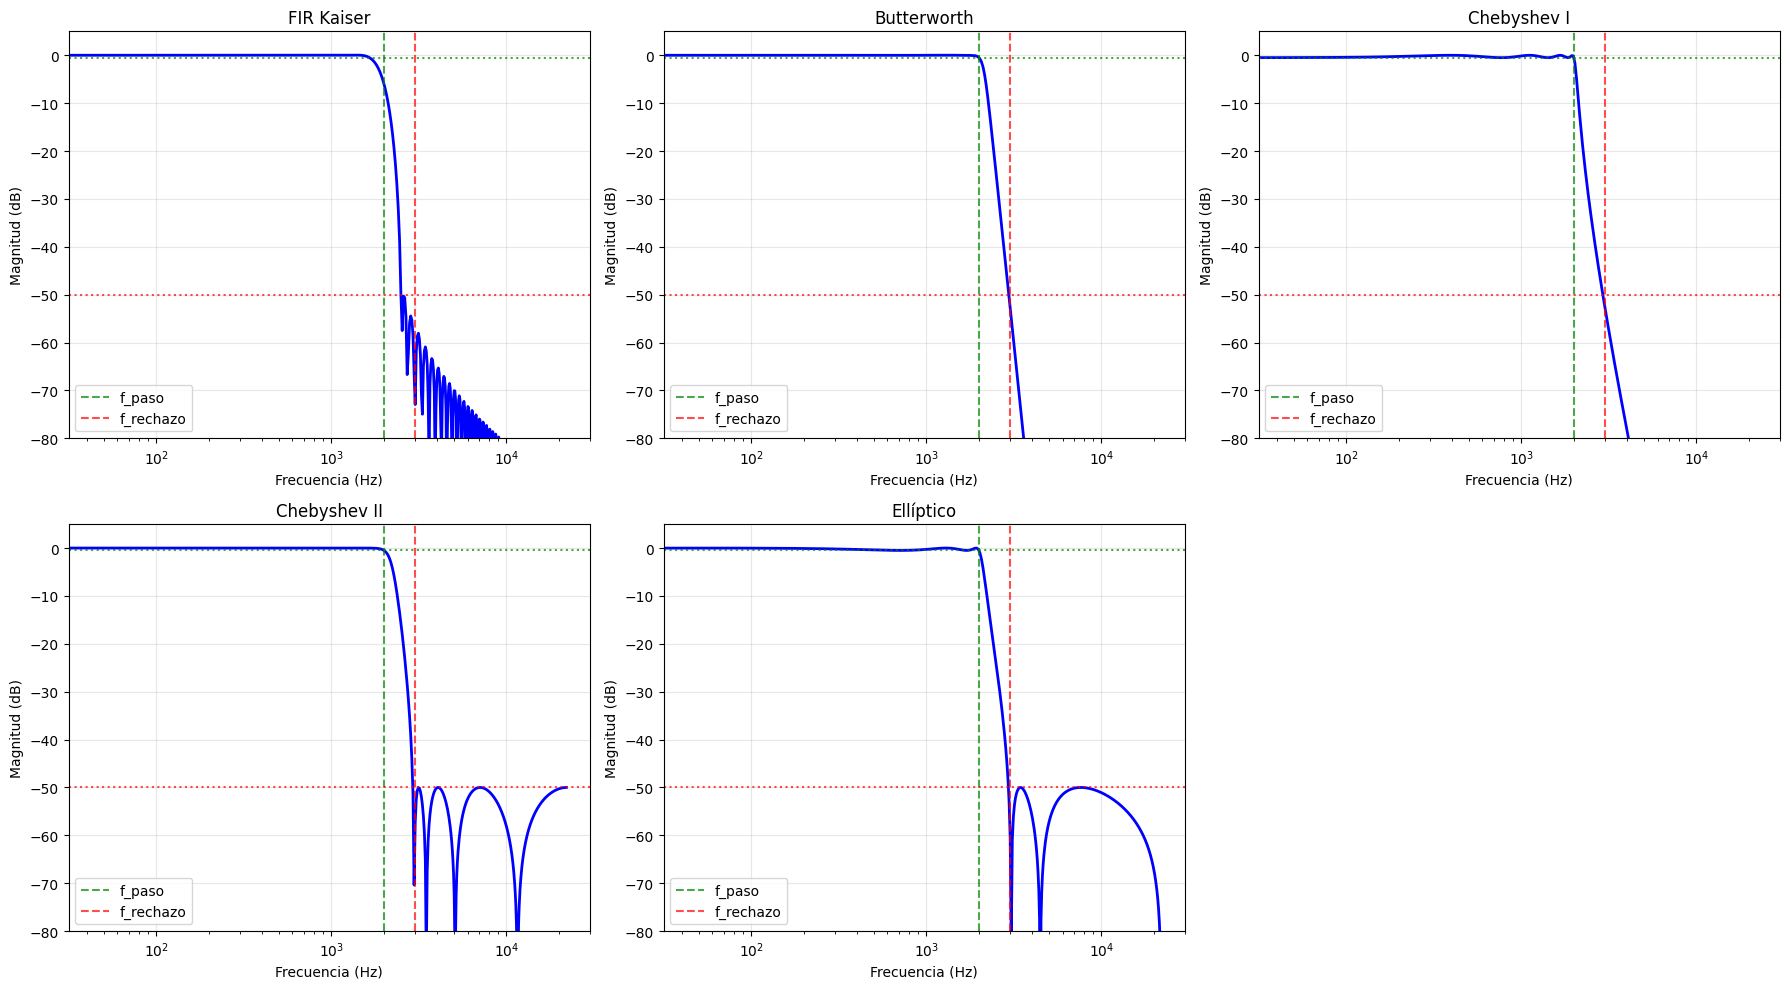

4. RESUMEN DE EFICIENCIA COMPUTACIONAL:
Filtro          Coef.  Mult/muestra Retardo  Cumple
--------------------------------------------------
FIR Kaiser      131    131          65.0     No    
Butterworth     35     35           35.6     Si    
Chebyshev I     17     17           22.4     Si    
Chebyshev II    17     17           10.9     Si    
Ellíptico       11     11           12.1     Si    


/var/folders/mq/1rf9bn6s6wg2bxvp1xqznkfr0000gn/T/ipykernel_75399/2816286202.py:134: UserWarning: The filter's denominator is extremely small at frequencies [0.000, 0.006, 0.012, 0.018, 0.025, 0.031, 0.037, 0.043, 0.049, 0.055, 0.061, 0.067, 0.074, 0.080, 0.086, 0.092, 0.098, 0.104, 0.110, 0.117, 0.123, 0.129, 0.135, 0.141, 0.147, 0.153, 0.160, 0.166, 0.172, 0.178, 0.184, 0.190, 0.196, 0.202, 0.209, 0.215, 0.221, 0.227, 0.233, 0.239, 0.245, 0.252, 0.258, 0.264, 0.270, 0.276, 0.282, 0.288, 0.295, 0.301, 0.307, 0.313, 0.319, 0.325, 0.331, 0.337, 0.344, 0.350, 0.356, 0.362, 0.368, 0.374, 0.380, 0.387, 0.393, 0.399, 0.405, 0.411, 0.417, 0.423, 0.430, 0.436, 0.442, 0.448, 0.454, 0.460, 0.466, 0.472, 0.479, 0.485, 0.491, 0.497, 0.503, 0.509, 0.515, 0.522, 0.528, 0.534, 0.540, 0.546, 0.552, 0.558, 0.565, 0.571, 2.571, 2.577, 2.583, 2.589, 2.595, 2.602, 2.608, 2.614, 2.620, 2.626, 2.632, 2.638, 2.645, 2.651, 2.657, 2.663, 2.669, 2.675, 2.681, 2.688, 2.694, 2.700, 2.706, 2.712, 2.718, 2.724, 2.7

In [34]:
fs_spec = 44100
f_paso = 2000
f_rechazo = 3000
ripple_max = 0.5
aten_min = 50

nyq_spec = fs_spec / 2
f_paso_norm = f_paso / nyq_spec
f_rechazo_norm = f_rechazo / nyq_spec
delta_f = (f_rechazo - f_paso) / fs_spec

A = aten_min
if A <= 21:
    beta = 0
elif A <= 50:
    beta = 0.5842 * (A - 21)**0.4 + 0.07886 * (A - 21)
else:
    beta = 0.1102 * (A - 8.7)

M_kaiser = np.ceil((A - 8) / (2.285 * 2 * np.pi * delta_f))
print(f"\n1. FILTRO FIR (Kaiser):")
print(f"   Orden estimado M = {M_kaiser:.0f}")
print(f"   β estimado = {beta:.2f}")

h_fir_opt = signal.firwin(int(M_kaiser) + 1, f_paso_norm, window=('kaiser', beta))
f_fir, H_fir = signal.freqz(h_fir_opt, 1, fs=fs_spec)

print(f"\n2. FILTROS IIR:")

wp, ws = f_paso_norm, f_rechazo_norm
N_butter, Wn_butter = signal.buttord(wp, ws, ripple_max, aten_min)
print(f"   Butterworth: Orden N = {N_butter}")

N_cheby1, Wn_cheby1 = signal.cheb1ord(wp, ws, ripple_max, aten_min)
print(f"   Chebyshev I: Orden N = {N_cheby1}")

N_cheby2, Wn_cheby2 = signal.cheb2ord(wp, ws, ripple_max, aten_min)
print(f"   Chebyshev II: Orden N = {N_cheby2}")

N_ellip, Wn_ellip = signal.ellipord(wp, ws, ripple_max, aten_min)
print(f"   Ellíptico: Orden N = {N_ellip}")

filtros_optimizados = {}

filtros_optimizados['FIR Kaiser'] = (h_fir_opt, np.array([1]))

b_butter, a_butter = signal.butter(N_butter, Wn_butter)
filtros_optimizados['Butterworth'] = (b_butter, a_butter)

b_cheby1, a_cheby1 = signal.cheby1(N_cheby1, ripple_max, Wn_cheby1)
filtros_optimizados['Chebyshev I'] = (b_cheby1, a_cheby1)

b_cheby2, a_cheby2 = signal.cheby2(N_cheby2, aten_min, Wn_cheby2)
filtros_optimizados['Chebyshev II'] = (b_cheby2, a_cheby2)

b_ellip, a_ellip = signal.ellip(N_ellip, ripple_max, aten_min, Wn_ellip)
filtros_optimizados['Ellíptico'] = (b_ellip, a_ellip)

print(f"\n3. VERIFICACIÓN DE ESPECIFICACIONES:")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (nombre, (b, a)) in enumerate(filtros_optimizados.items()):
    f, H = signal.freqz(b, a, fs=fs_spec)
    mag_db = 20 * np.log10(np.abs(H))

    if i < len(axes):
        axes[i].semilogx(f, mag_db, 'b-', linewidth=2)
        axes[i].axvline(f_paso, color='green', linestyle='--', alpha=0.7, label='f_paso')
        axes[i].axvline(f_rechazo, color='red', linestyle='--', alpha=0.7, label='f_rechazo')
        axes[i].axhline(-ripple_max, color='green', linestyle=':', alpha=0.7)
        axes[i].axhline(-aten_min, color='red', linestyle=':', alpha=0.7)
        axes[i].set_title(f'{nombre}')
        axes[i].set_ylabel('Magnitud (dB)')
        axes[i].set_xlabel('Frecuencia (Hz)')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        axes[i].set_ylim([-80, 5])

    idx_paso = f <= f_paso
    if np.any(idx_paso):
        max_paso = np.max(mag_db[idx_paso])
        min_paso = np.min(mag_db[idx_paso])
        ripple_real = max_paso - min_paso
    else:
        ripple_real = 0

    idx_rechazo = f >= f_rechazo
    if np.any(idx_rechazo):
        aten_real = -np.max(mag_db[idx_rechazo])
    else:
        aten_real = 0

    n_coef = len(b) + len(a) - 1 if len(a) > 1 else len(b)

    if len(a) == 1:  # FIR
        retardo = (len(b) - 1) / 2
    else:  # IIR
        w, gd = signal.group_delay((b, a), fs=fs_spec)
        retardo = gd[0]

    cumple_ripple = ripple_real <= ripple_max
    cumple_aten = aten_real >= aten_min

    print(f"{nombre}:")
    print(f"  Coeficientes totales: {n_coef}")
    print(f"  Ripple paso: {ripple_real:.2f} dB {'Si' if cumple_ripple else 'No'}")
    print(f"  Atenuación rechazo: {aten_real:.1f} dB {'Si' if cumple_aten else 'No'}")
    print(f"  Retardo: {retardo:.1f} muestras")
    print(f"  Cumple especificaciones: {'SÍ' if (cumple_ripple and cumple_aten) else 'NO'}")
    print()

if len(filtros_optimizados) < len(axes):
    for i in range(len(filtros_optimizados), len(axes)):
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

print("4. RESUMEN DE EFICIENCIA COMPUTACIONAL:")
print("=" * 40)
print(f"{'Filtro':<15} {'Coef.':<6} {'Mult/muestra':<12} {'Retardo':<8} {'Cumple':<6}")
print("-" * 50)

for nombre, (b, a) in filtros_optimizados.items():
    n_coef = len(b) + len(a) - 1 if len(a) > 1 else len(b)
    mult_por_muestra = len(b) + len(a) - 1 if len(a) > 1 else len(b)

    if len(a) == 1:  # FIR
        retardo = (len(b) - 1) / 2
    else:  # IIR
        w, gd = signal.group_delay((b, a), fs=fs_spec)
        retardo = gd[0]

    f, H = signal.freqz(b, a, fs=fs_spec)
    mag_db = 20 * np.log10(np.abs(H))

    idx_paso = f <= f_paso
    idx_rechazo = f >= f_rechazo

    ripple_ok = True
    aten_ok = True

    if np.any(idx_paso):
        ripple_real = np.max(mag_db[idx_paso]) - np.min(mag_db[idx_paso])
        ripple_ok = ripple_real <= ripple_max

    if np.any(idx_rechazo):
        aten_real = -np.max(mag_db[idx_rechazo])
        aten_ok = aten_real >= aten_min

    cumple = "Si" if (ripple_ok and aten_ok) else "No"

    print(f"{nombre:<15} {n_coef:<6} {mult_por_muestra:<12} {retardo:<8.1f} {cumple:<6}")

### Ejercicio 2: Comparación de diferentes órdenes y ventanas

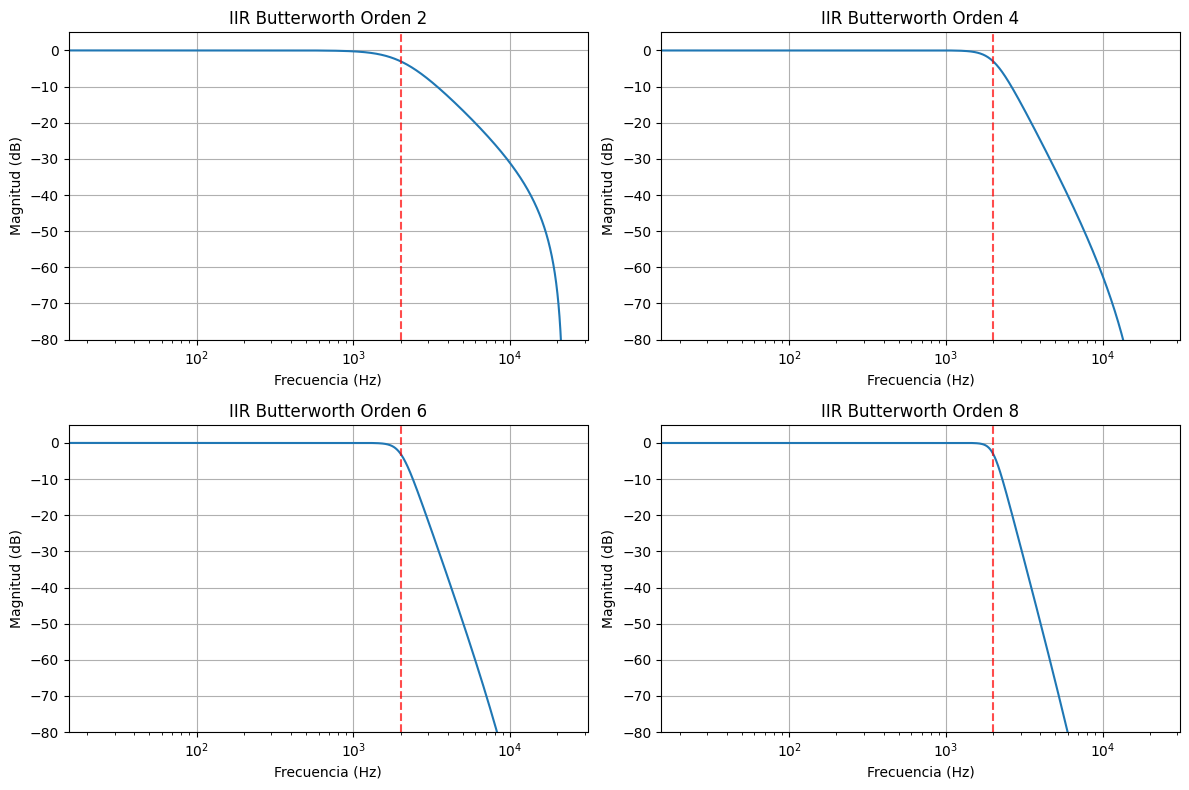

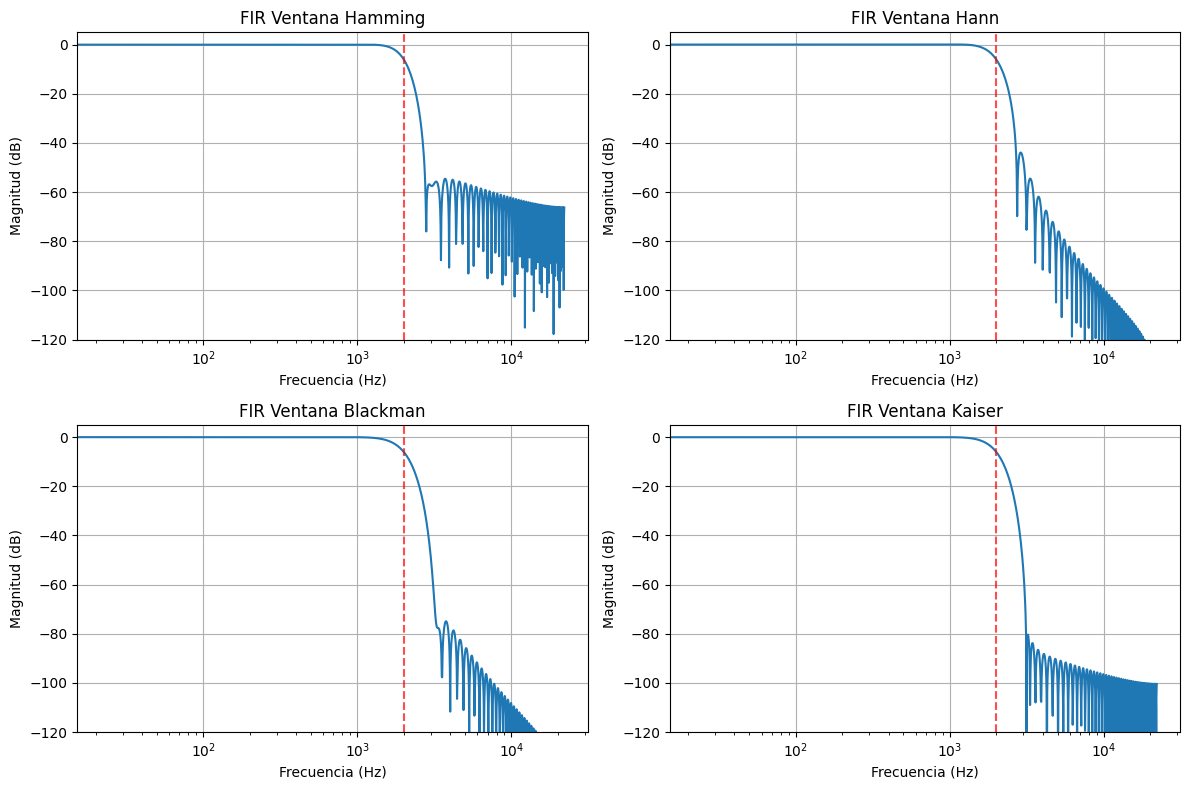

In [31]:
fs_test = 44100
cut_test = 2000

orders = [2, 4, 6, 8]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, order in enumerate(orders):
    b, a = fd.design_iir_butter_lowpass(fs_test, cut_test, order=order)
    f, H = fd.freq_response_from_taps(b, a, fs=fs_test)

    axes[i].semilogx(f, 20*np.log10(np.abs(H)))
    axes[i].set_title(f'IIR Butterworth Orden {order}')
    axes[i].set_ylabel('Magnitud (dB)')
    axes[i].set_xlabel('Frecuencia (Hz)')
    axes[i].grid(True)
    axes[i].axvline(cut_test, color='red', linestyle='--', alpha=0.7)
    axes[i].set_ylim([-80, 5])

plt.tight_layout()
plt.show()

windows = ['hamming', 'hann', 'blackman', 'kaiser']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, window in enumerate(windows):
    if window == 'kaiser':
        h = fd.design_fir_lowpass(fs_test, cut_test, num_coef=101, window=('kaiser', 8))
    else:
        h = fd.design_fir_lowpass(fs_test, cut_test, num_coef=101, window=window)

    f, H = fd.freq_response_from_taps(h, 1, fs=fs_test)

    axes[i].semilogx(f, 20*np.log10(np.abs(H)))
    axes[i].set_title(f'FIR Ventana {window.capitalize()}')
    axes[i].set_ylabel('Magnitud (dB)')
    axes[i].set_xlabel('Frecuencia (Hz)')
    axes[i].grid(True)
    axes[i].axvline(cut_test, color='red', linestyle='--', alpha=0.7)
    axes[i].set_ylim([-120, 5])

plt.tight_layout()
plt.show()